In [1]:
# импортируем все что нужно
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from typing import List
from tqdm.auto import tqdm
import shutil

c:\Users\divin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# важно! ноутук должен лежать в той же папке что и папка archive, где хранятся все изначальные данные
notebook_path = Path.cwd()
data_path = notebook_path / "archive"

In [3]:
# пути до всех необходимых файлов
attr_path = data_path / "list_attr_celeba.csv"
bbox_path = data_path / "list_bbox_celeba.csv"
landmark_path = data_path / "list_landmarks_celeba.txt"
identity_path = data_path / "identity_CelebA.txt"

In [4]:
# создаем папки для сохранения выбранных изображений
output_dir = notebook_path / "data-for-alignment"
images_dir = output_dir / "images"
output_dir.mkdir(exist_ok=True)
images_dir.mkdir(exist_ok=True)

In [5]:
# загружаем данные из файлов в датафреймы

df_attr = pd.read_csv(attr_path)
df_bbox = pd.read_csv(bbox_path)

columns_landmark = [
    "image_id",
    "lefteye_x", "lefteye_y",
    "righteye_x", "righteye_y",
    "nose_x", "nose_y",
    "leftmouth_x", "leftmouth_y",
    "rightmouth_x", "rightmouth_y"
]

df_landmark = pd.read_csv(
    landmark_path,          
    sep=r"\s+",           
    skiprows=2,           
    names=columns_landmark
)

columns_identity = [
    "image_id",
    "identity"
]

df_identity = pd.read_csv(
    identity_path,          
    sep=r"\s+",           
    names=columns_identity
)

In [6]:
# объединяем все датафреймы в один по столбцу image_id

df = df_attr.merge(df_bbox, on="image_id", how="inner")
df = df.merge(df_landmark, on="image_id", how="inner")
df = df.merge(df_identity, on="image_id", how="inner")

df_original = df.copy() # на всякий сохраняем оригинальный датафрейм
df_prepared = df.copy() # а этот будем менять

print(df_prepared.shape)

(202599, 56)


In [7]:
# сколько изображений мы хотим в итоге получить
TARGET_N = 25000  

SEED = 21 # фиксируем сид для воспроизводимости

# минимальные размеры bbox
MIN_BBOX_W = 100
MIN_BBOX_H = 100

In [8]:
# Выкидываем все картински с Blurry == 1
df_prepared = df_prepared[df_prepared["Blurry"] == -1].copy()

# Выкидываем все картинки с bbox меньше минимальных размеров
df_prepared = df_prepared[(df_prepared["width"] >= MIN_BBOX_W) & (df_prepared["height"] >= MIN_BBOX_H)].copy()

Text(0.5, 1.0, 'Distribution of Images per Identity')

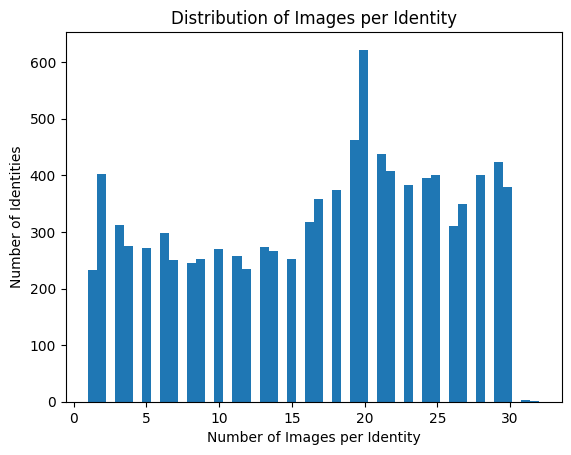

In [9]:
# построим гистограмму распределения количества изображений по identity
identity_counts = df_prepared['identity'].value_counts()
plt.hist(identity_counts, bins=50)
plt.xlabel("Number of Images per Identity")
plt.ylabel("Number of Identities")
plt.title("Distribution of Images per Identity")

In [10]:
# для FaceRecognition важно чтобы на каждую identity было достаточно изображений

# Сколько фото брать на одну личность 
PHOTOS_PER_ID = 25

# Сколько разных identity хотим 
N_IDENTITIES = TARGET_N // PHOTOS_PER_ID  

In [11]:
# Оставляем только identity у которых достаточно картинок >= PHOTOS_PER_ID
id_counts = df_prepared.groupby("identity")["image_id"].count()
good_ids = id_counts[id_counts >= PHOTOS_PER_ID].index
df_id = df_prepared[df_prepared["identity"].isin(good_ids)].copy()
df_id.shape

(62555, 56)

In [12]:
# Выбираем N_IDENTITIES 
rng = np.random.RandomState(SEED)
chosen_ids = rng.choice(df_id["identity"].unique(), size=N_IDENTITIES, replace=False)

df_id = df_id[df_id["identity"].isin(chosen_ids)].copy()

In [13]:
# Из каждой identity берём PHOTOS_PER_ID картинок
df_id_balanced = (
    df_id.groupby("identity", group_keys=False)
         .apply(lambda g: g.sample(n=PHOTOS_PER_ID, random_state=SEED))
)

C:\Users\divin\AppData\Local\Temp\ipykernel_12468\3072266892.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=PHOTOS_PER_ID, random_state=SEED))


In [14]:
# проверяем что все ок
print("Balanced pool:", df_id_balanced.shape)
print("Identities in pool:", df_id_balanced["identity"].nunique())

Balanced pool: (25000, 56)
Identities in pool: 1000


In [15]:
# на всякий проверим, что смоими выборками мы не сильно исказили распределение атрибутов 

# выбираем только колоки с аттрибутами
exclude = {"image_id", "x_1", "y_1", "width", "height"}
attr_cols = [c for c in df.columns if c not in exclude]

comparison = []

# проходимся по аттрибутам
for col in attr_cols:
    
    # считаем долю в процентах положительных примеров в оригинальном и отобранном датасете
    base_pos = (df_original[col] == 1).mean() * 100
    sel_pos = (df_id_balanced[col] == 1).mean() * 100

    # читаем разницу
    diff = sel_pos - base_pos

    comparison.append({
        "attribute": col,
        "original": round(base_pos, 2),
        "selected": round(sel_pos, 2),
        "difference": round(diff, 2)
    })

cmp_df = pd.DataFrame(comparison).sort_values(
    "difference", key=lambda s: s.abs(), ascending=False
)

cmp_df

,attribute,original,selected,difference
1,Arched_Eyebrows,26.70,41.30,14.60
36,Wearing_Lipstick,47.24,60.03,12.78
6,Big_Lips,24.08,36.70,12.62
2,Attractive,51.25,63.16,11.91
25,Oval_Face,28.41,18.06,-10.36
18,Heavy_Makeup,38.69,48.54,9.84
20,Male,41.68,32.26,-9.41
3,Bags_Under_Eyes,20.46,27.40,6.94
34,Wearing_Earrings,18.89,25.13,6.24
39,Young,77.36,83.45,6.09


Вообще говоря тут видно что то, как мы выбирали картинки, изменило распределение по признакам

Но с моей стороны эти изменения небольшие, в пределах 10%

По хорошему надо бы сверху еще докинуть фильтров, что бы в конечной выборке было например 50% мужчин, 5% с очками, 5% с шапками и прочим

Я изначально так и делал, но потом я не заметил чтобы это как-то изменило метрики для выравливания или распознования

Так что в финальной версии я все это выкинул и обучающие данные я выбираю лишь по identites

In [16]:
# Дальше работаем только с этим пулом
df_final = df_id_balanced.copy()

In [17]:
# проверяем финальный размер
df_final.shape

(25000, 56)

In [18]:
# проверяем сколько уникальных identity
df_final["identity"].nunique()


1000

Text(0.5, 1.0, 'Distribution of Images per Identity')

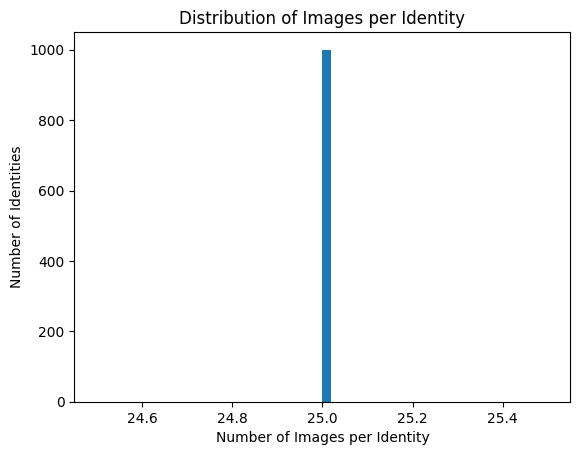

In [19]:
# на всякий снова построим гистограмму распределения количества изображений по identity
identity_counts = df_final['identity'].value_counts()
plt.hist(identity_counts, bins=50)
plt.xlabel("Number of Images per Identity")
plt.ylabel("Number of Identities")
plt.title("Distribution of Images per Identity")

дальше записываем "selected_images.csv" и переносим выбранные картинки в папку selected images

все это дело зипуем и это будет inputs data для следующего шага с Stacked Hourglass

In [20]:
df_final.to_csv(output_dir /"selected_images.csv", index=False)

In [21]:
for r in tqdm(df_final.itertuples(index=False), total=len(df_final)):
    img_name = r.image_id

    matches = list(data_path.rglob(img_name))
    img_path = matches[0]

    new_image_path =  images_dir / img_name
    shutil.copy(img_path, new_image_path)

100%|██████████| 25000/25000 [1:18:11<00:00,  5.33it/s]     


In [22]:
file_count = len([f for f in images_dir.iterdir() if f.is_file()])
file_count

25000

In [23]:
zip_path = shutil.make_archive(str(output_dir), 'zip', root_dir=output_dir)